In [1]:
import pandas       as pd
import numpy        as np

from sklearn.model_selection import train_test_split
from sklearn                 import linear_model

from IPython.display         import display, Markdown, Latex

# Importando minhas bibliotecas
import sys; sys.path.append('../../gridsearch/itea-gridsearch')

import itea               as sr         # Algoritmo ITEA

import matplotlib.pyplot  as plt

from pylab                import rcParams
from scipy                import stats


plt.rcParams['text.usetex']    = True
plt.rcParams['axes.axisbelow'] = True

pd.set_option('display.max_colwidth', None) 

print('Done')

Done


In [2]:
class Wrapper:
    def __init__(self, funs, funs_dx, bestsol, X_train, y_train, label):
        self.label   = label

        self.funs    = funs
        self.funs_dx = funs_dx
        
        self.bestsol = bestsol

        self.X_train    = X_train
        self.y_train    = y_train
        self.n_vars     = X_train.shape[1]

        self.beta_varcovar = self._find_beta_varcovar(X_train, y_train)
        

    def _IT_dx_to_latex(self, dydx):  

        str_it = []
        for i, (c, f, terms) in enumerate(zip(self.bestsol.coeffs, self.bestsol.funcs, self.bestsol.terms)):
            if c != 0.0 and terms[dydx]!=0:
                try:
                    terms_dx = terms.copy()
                    terms_dx[dydx] -= 1
                    
                    t1 = f'{self.funs[f][terms_dx]}'
                    t2 = f'{round(c*terms[dydx], 3)} \cdot {self.funs_dx[f][terms]}'
                    
                    latex = f'{t2} \cdot {t1}'
                    
                    str_it.append(latex)
                except:
                    continue

        if len(str_it)==0:
            raise Exception('Null partial derivative')
        
        return ' + '.join(str_it).replace(r'\cdot 1 \cdot', ' \cdot')
        
    def _IT_to_latex(self):

        str_it = []
        for i, (c, f, terms) in enumerate(zip(self.bestsol.coeffs, self.bestsol.funcs, self.bestsol.terms)):
            if c != 0.0:
                try:
                    latex = f'{round(c, 3)} \cdot {self.funs[f][terms]}'.replace(r'1.0 \cdot', '')
    
                    str_it.append(latex)
                except: # Every exponent is zero
                    continue
                
        # at least, the intercept will be there
        return ' + '.join(str_it + [f'{self.bestsol.bias}'])
    
    def _find_beta_varcovar(self, X, y):

        try:
            var_covar_matrix = np.zeros( (self.bestsol.len + 1, self.bestsol.len + 1) )
            
            MSE = mean_squared_error(y, self.bestsol.predict(X))
            
            D = np.ones( (len(X), self.bestsol.len + 1) ) 
            
            D[:, 1:] = self.bestsol._eval(X)
            
            D = D * np.array([self.bestsol.bias] + self.bestsol.coeffs).T
            
            return MSE * np.linalg.inv((D.T @ D))
        except:
            return  np.zeros( (self.bestsol.len + 1, self.bestsol.len + 1) )


    def _find_itexpr_MEM_dx(self, dydx, representative):

        assert representative in ['mean', 'median', 'Q1', 'Q3'], \
            "Representative function does not exist in implementation."

        # Calculating the representative value for covariables
        expected = []
        for i in range(self.bestsol.len):

            intermed_interaction = self.bestsol.terms[i].copy() 

            intermed_interaction[dydx] = 0

            if representative=='mean':
                expected.append(np.mean(np.prod(self.X_train**intermed_interaction, axis=1)))
            elif representative=='median':
                expected.append(np.median(np.prod(self.X_train**intermed_interaction, axis=1)))    
            elif representative=='Q1':
                expected.append(np.percentile(np.prod(self.X_train**intermed_interaction, axis=1), q=25))    
            elif representative=='Q3':
                expected.append(np.percentile(np.prod(self.X_train**intermed_interaction, axis=1), q=75))    

            
        def marginal_effect(x):
            # Takes only one value. All other covariables are fixed
            # in representative values
            # Saving the coefficients
            coeffs_dx = np.zeros( (1, self.bestsol.len + 1) )

            it_dx = 0

            for i in range(self.bestsol.len):
                pi = np.prod(x**self.bestsol.terms[i][dydx] * expected[i])
                pi_d = self.bestsol.terms[i][dydx]*pi/x

                gi_d = self.funs_dx[self.bestsol.funcs[i]](pi) * pi_d

                it_dx += self.bestsol.coeffs[i]*gi_d
                coeffs_dx[0, i+1] = gi_d

            return it_dx, coeffs_dx
        
        return marginal_effect


    def MEM(self, representative='mean', show_err=True, figsize=(10, 3), save_path=None, show=False):
    
        var_descriptions = [
            f'$x_0$ - kilograms of cement in a $m^3$ mixture',
            f'$x_1$ - kilograms of blast furnace slag in a $m^3$ mixture',
            f'$x_2$ - kilograms of fly ash in a $m^3$ mixture',
            f'$x_3$ - kilograms of water in a $m^3$ mixture',
            f'$x_4$ - kilograms of superplasticizer in a $m^3$ mixture',
            f'$x_5$ - kilograms of coarse aggregate in a $m^3$ mixture',
            f'$x_6$ - kilograms of fine aggregate in a $m^3$ mixture',
            f'$x_7$ - age'
        ]
        
        for dydx in range(self.n_vars):
            with plt.style.context("seaborn-paper"):   
                fig, ax = plt.subplots(figsize=(12, 12))

                bestsol_dx = self._find_itexpr_MEM_dx(dydx, representative)

                xs = np.linspace(np.min(self.X_train[:, dydx]), np.max(self.X_train[:, dydx]), 250)
                ys = [bestsol_dx(x)[0] for x in xs]

                self.beta_varcovar = self._find_beta_varcovar(self.X_train, self.y_train)
                
                variance = [(bestsol_dx(x)[1] @ self.beta_varcovar @ bestsol_dx(x)[1].T)[0, 0] for x in xs]

                df = len(self.X_train) - 1

                IC = [stats.t.ppf(1-0.025, df)*np.sqrt(v)/np.sqrt(df) for v in variance]

                ax.plot(xs, ys, lw=1.5, ls='-', color='b')

                if show_err:
                    ax.fill_between(
                        xs,
                        [y+ic for y, ic in zip(ys, IC)],
                        [y-ic for y, ic in zip(ys, IC)], 
                        alpha=0.25, color='b'
                    )

                ax.grid()
                ax.set_title(f'Marginal Effect of x{dydx} on Concrete data set.', fontsize=22)

                plt.tick_params(labelsize=22)
                
                var_name = self.label[dydx] if len(self.label)>dydx else f'x{dydx}'

                ax.set_xlabel(var_descriptions[dydx], fontsize=22)
                ax.set_ylabel(f'Marginal Effect', fontsize=22)

                fig.tight_layout()

                if save_path:
                    fig.savefig(f'{save_path}-{var_name}.eps', dpi=300)

                if not show:
                    plt.close()

        return fig
    
    def gradient(self, x, representative='mean'):
        g = []
        for dydx in range(self.n_vars):
            bestsol_dx = self._find_itexpr_MEM_dx(dydx, representative)
            
            g.append(bestsol_dx(x[dydx])[0])
            
            if np.isnan(g[-1]):
                print(g[-1])
                print(dydx)
                print(x)
        return g

In [3]:
class latex_nom_den:
    def __init__(self):
        pass
    
    def _get_frac(self, exponents):
    
        if  np.all(exponents == 0):
            raise Exception('All exponents are zero')

        # For the coefficients different than zero, they can be
        # numerators or denominators of the fractions
        num = r' \cdot '.join(
            [fr'x{i}^{ {e} }' for i, e in enumerate(exponents) if e>0]
        ).replace(r'^{1}', '')

        den = r' \cdot '.join(
            [fr'x{i}^{ {-e} }' for i, e in enumerate(exponents) if e<0]
        ).replace(r'^{1}', '')

        if len(den)==0:
            return num
        elif len(num)==0:
            return r'\frac{1}{' + den + r'}'
        else:
            return r'\frac{' + num + r'}{' + den + '}'

        
# ----------------------------------------------------
# Transformation functions and its derivatives

class func_id(latex_nom_den):
    def __call__(self, x):
        return x
    def __getitem__(self, exponents):
        return self._get_frac(exponents)
    def __str__(self):
        return r'x'

class func_id_dx(latex_nom_den):
    def __call__(self, x):
        return 1.0
    def __getitem__(self, exponents):
        return '1'
    def __str__(self):
        return r'1'



class func_sin(latex_nom_den):
    def __call__(self, x):
        return np.sin(x)
    def __getitem__(self, exponents):
        return f'sin({self._get_frac(exponents)})'
    def __str__(self):
        return r'sin(x)'

class func_sin_dx(latex_nom_den):
    def __call__(self, x):
        return np.cos(x)    
    def __getitem__(self, exponents):
        return f'cos({self._get_frac(exponents)})'
    def __str__(self):
        return r'cos(x)'
    


class func_cos(latex_nom_den):
    def __call__(self, x):
        return np.cos(x)
    def __getitem__(self, exponents):
        return f'cos({self._get_frac(exponents)})'
    def __str__(self):
        return r'cos(x)'

class func_cos_dx(latex_nom_den):
    def __call__(self, x):
        return -np.sin(x)    
    def __getitem__(self, exponents):
        return f'-sin({self._get_frac(exponents)})'
    def __str__(self):
        return r'-sin(x)'



class func_tanh(latex_nom_den):
    def __call__(self, x):
        return np.tanh(x)
    def __getitem__(self, exponents):
        return f'tanh({self._get_frac(exponents)})'
    def __str__(self):
        return r'tanh(x)'

class func_tanh_dx(latex_nom_den):
    def __call__(self, x):
        return np.power((1/np.cosh(x)), 2)   
    def __getitem__(self, exponents):
        return r'\frac{1}{cosh(' + f'{self._get_frac(exponents)}' + r')^2}'
    def __str__(self):
        return r'\frac{1}{cosh(x)^2}'
   
    
    
class func_gauss(latex_nom_den):
    def __call__(self, x):
        return np.exp( (-x**2)/(2) )
    def __getitem__(self, exponents):
        return r'e^{\frac{\left (-' + f'{self._get_frac(exponents)}' + r'\right )^{2}}{2}}'
    def __str__(self):
        return r'e^{\frac{-x^{2}}{2}}'

class func_gauss_dx(latex_nom_den):
    def __call__(self, x):
        return -x * np.exp( (-x**2)/(2) )
    def __getitem__(self, exponents):
        return r'-' + f'{self._get_frac(exponents)}' + r'\cdot e^{\frac{\left (-' + f'{self._get_frac(exponents)}' + r'\right )^{2}}{2}}'
    def __str__(self):
        return r'-x \cdot e^{\frac{-x^{2}}{2}}'
    


class func_exp1(latex_nom_den):
    def __call__(self, x):
        return np.exp( x ) + 1
    def __getitem__(self, exponents):
        return r'e^{' + f'{self._get_frac(exponents)}' + r'} + 1'
    def __str__(self):
        return r'e^{x} + 1'

class func_exp1_dx(latex_nom_den):
    def __call__(self, x):
        return np.exp( x )
    def __getitem__(self, exponents):
        return r'e^{' + f'{self._get_frac(exponents)}' + r'}'
    def __str__(self):
        return r'e^{x}'



class func_sqrt(latex_nom_den):
    def __call__(self, x):
        return np.sqrt( x )
    def __getitem__(self, exponents):
        return r'\sqrt{' + f'{self._get_frac(exponents)}' + r'}'
    def __str__(self):
        return r'\sqrt{x}'

class func_sqrt_dx(latex_nom_den):
    def __call__(self, x):
        return 1/(2*np.sqrt( x ))
    def __getitem__(self, exponents):
        return r'\frac{1}{2 \cdot \sqrt{' + f'{self._get_frac(exponents)}' + r'}}'
    def __str__(self):
        return r'\frac{1}{2 \cdot\sqrt{x}}'


class func_sqrtabs(latex_nom_den):
    def __call__(self, x):
        return np.sqrt(np.abs( x ))
    def __getitem__(self, exponents):
        return r'\sqrt{\left |' + f'{self._get_frac(exponents)}' + r'\right |}'
    def __str__(self):
        return r'\sqrt{\left | x \right |}'

class func_sqrtabs_dx(latex_nom_den):
    def __call__(self, x):
        return 1/(2*(np.abs( x )**(3/2)))
    def __getitem__(self, exponents):
        return r'\frac{1}{2 \cdot \left |' + f'{self._get_frac(exponents)}' + r'\right | ^{\frac{3}{2}}}'
    def __str__(self):
        return r'\frac{1}{2 \cdot \left | x \right | ^{\frac{3}{2}}}'


class func_log(latex_nom_den):
    def __call__(self, x):
        return np.ma.array(np.log( x ), mask=(np.isnan(np.log( x ))), fill_value=0).filled() 
    def __getitem__(self, exponents):
        return r'log{' + f'{self._get_frac(exponents)}' + r'}'
    def __str__(self):
        return r'log(x)'

class func_log_dx(latex_nom_den):
    def __call__(self, x):
        return np.ma.array(1/x, mask=(x==0.0), fill_value=1).filled()
    def __getitem__(self, exponents):
        return r'\frac{1}{' + f'{self._get_frac(exponents)}' + r'}'
    def __str__(self):
        return r'\frac{1}{x}'



class func_relu(latex_nom_den):
    def __call__(self, x):
        return np.ma.array(x, mask=(x<=0.0), fill_value=0).filled()
    def __getitem__(self, exponents):
        return r'max{0, ' + f'{self._get_frac(exponents)}' + r'}'
    def __str__(self):
        return r'max(0, x)'

class func_relu_dx(latex_nom_den):
    def __call__(self, x):
        negative_to_zero = np.ma.array(x, mask=(x<=0.0), fill_value=0).filled()
        positive_to_one  = np.ma.array(negative_to_zero, mask=(negative_to_zero>0), fill_value=1).filled()
        return positive_to_one
    def __getitem__(self, exponents):
        return r'1 if ' + f'{self._get_frac(exponents)}' + r'> 0 else 0'
    def __str__(self):
        return r"1 if x>0 else 0"

    
# -----------------------------------------------------
transf_funs = {
    "id"       : func_id(),

    "sin"      : func_sin(), 
    "cos"      : func_cos(),        
    "tanh"     : func_tanh(), 

    "gauss"    : func_gauss(),

    "sqrt"     : func_sqrt(),
    "sqrt.abs" : func_sqrtabs(),
    "relu"     : func_relu(),

    "exp1"     : func_exp1(),
    "log"      : func_log(),

}


transf_funs_dx = {
    "id"       : func_id_dx(),

    "sin"      : func_sin_dx(),
    "cos"      : func_cos_dx(),
    "tanh"     : func_tanh_dx(),
    "gauss"    : func_gauss_dx(),

    "sqrt"     : func_sqrt_dx(),
    "sqrt.abs" : func_sqrtabs_dx(),
    "relu"     : func_relu_dx(),

    "exp1"     : func_exp1_dx(),
    "log"      : func_log_dx(),
}

In [4]:
df_train = pd.read_csv('../../../datasets/commaSeparated/concrete-train-0.dat', sep=',', header=None)
df_test  = pd.read_csv('../../../datasets/commaSeparated/concrete-test-0.dat', sep=',', header=None)

label = df_train.columns.values[:-1]

X, y = df_train.iloc[:, :-1].values, df_train.iloc[:, -1].values

Xtest, ytest = df_test.iloc[:, :-1].values, df_test.iloc[:, -1].values

df_train.describe()

,0,1,2,3,4,5,6,7,8
count,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000
mean,279.433374,76.103762,54.288350,181.648786,6.174636,973.279854,772.910437,44.529126,35.833228
std,103.768874,86.345764,63.871075,21.365619,5.950490,77.079192,80.577603,61.453035,16.812266
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,191.675000,0.000000,0.000000,164.900000,0.000000,932.000000,732.050000,7.000000,23.677500
50%,272.700000,24.000000,0.000000,185.000000,6.400000,968.000000,778.450000,28.000000,33.870000
75%,349.000000,145.000000,118.300000,192.000000,10.100000,1028.400000,822.050000,56.000000,46.285000
max,540.000000,359.400000,195.000000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


-0.003*sqrt.abs(x3 * x6 * x7) + -11.89*log(x0^-2 * x5 * x6^2 * x7^-1) + 5.87*tanh(x0^2 * x3 * x4^2 * x5^-2 * x7^-1) + -0.292*(x3) + 0.0*(x1 * x3^2 * x6^2) + 157.799
6.895607406819644
[-0.0032053831919384894, -11.889602618243066, 5.86973844536498, -0.29204583822958635, 3.0162539133016253e-12]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

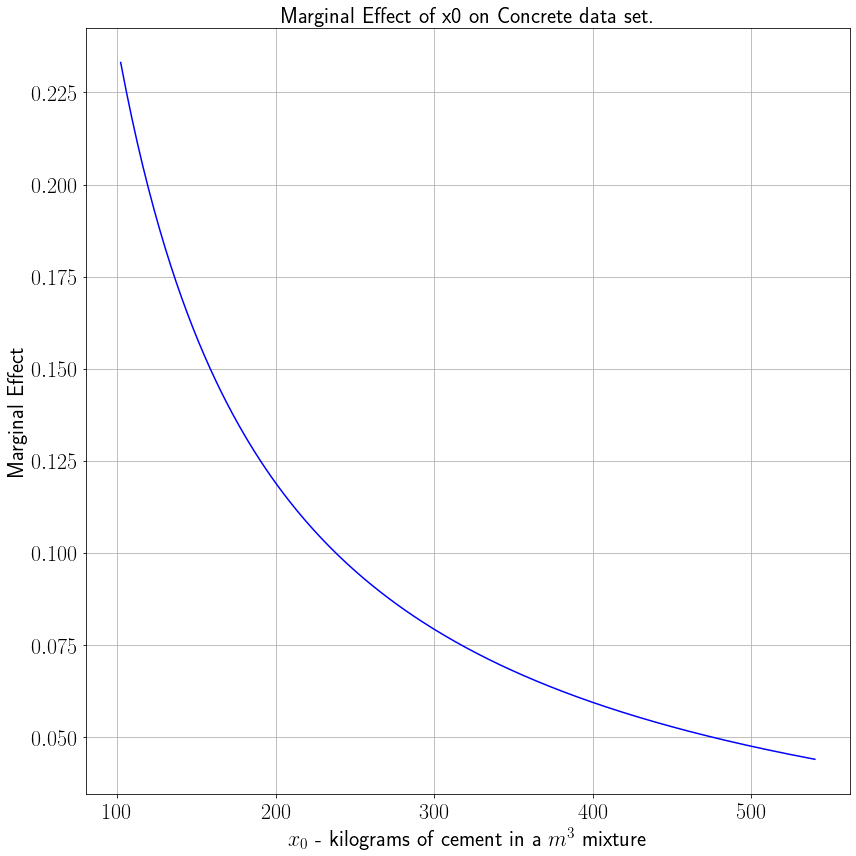

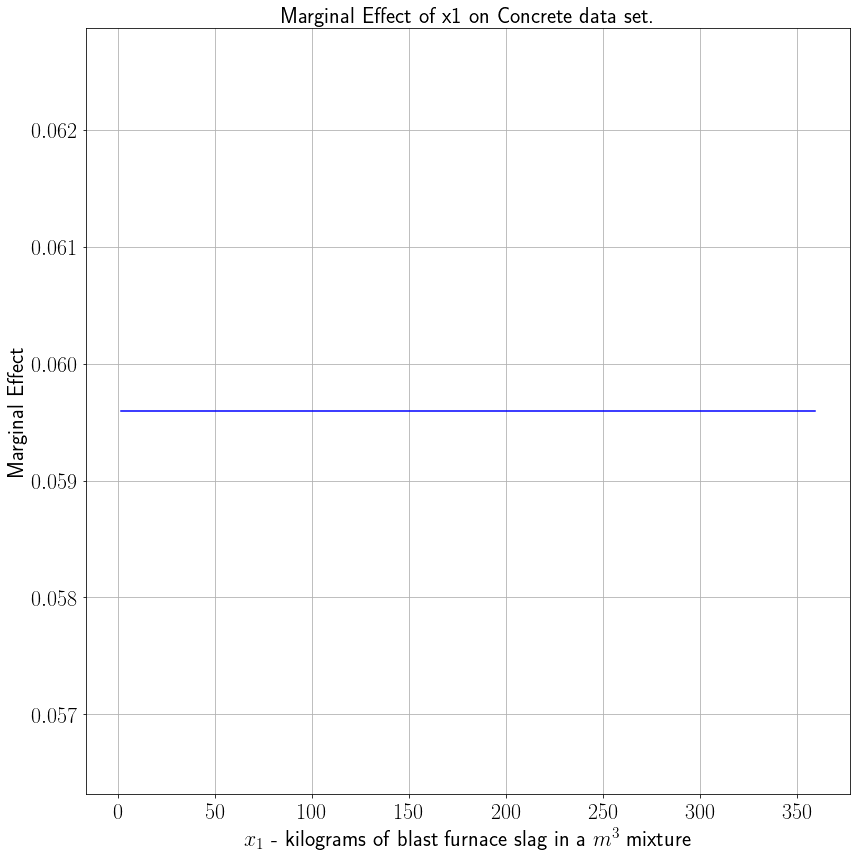

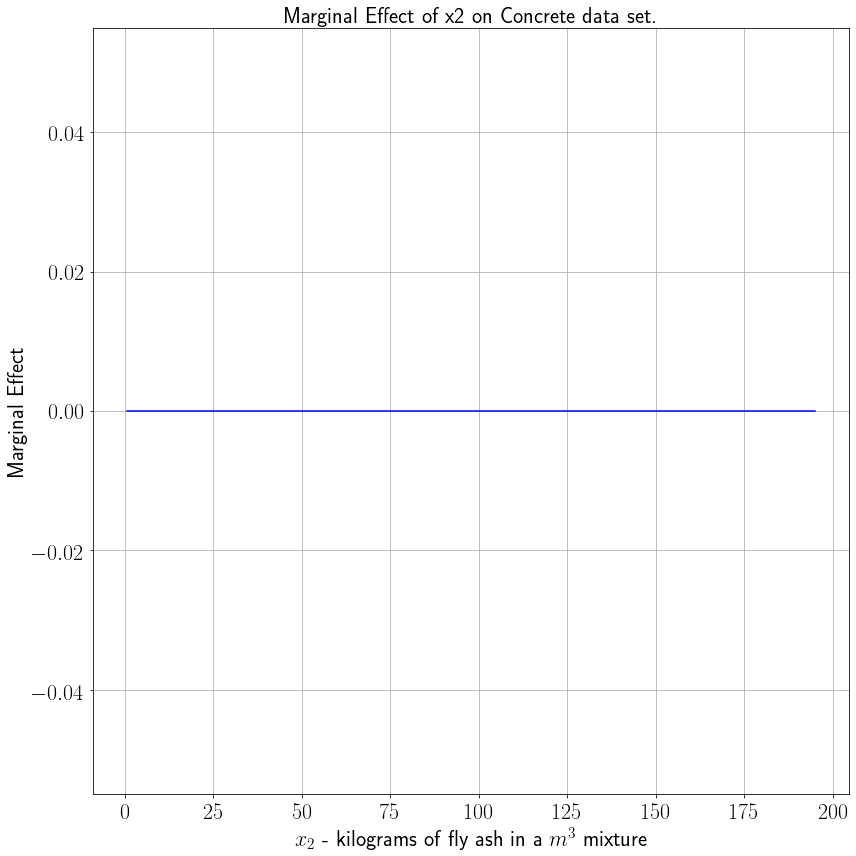

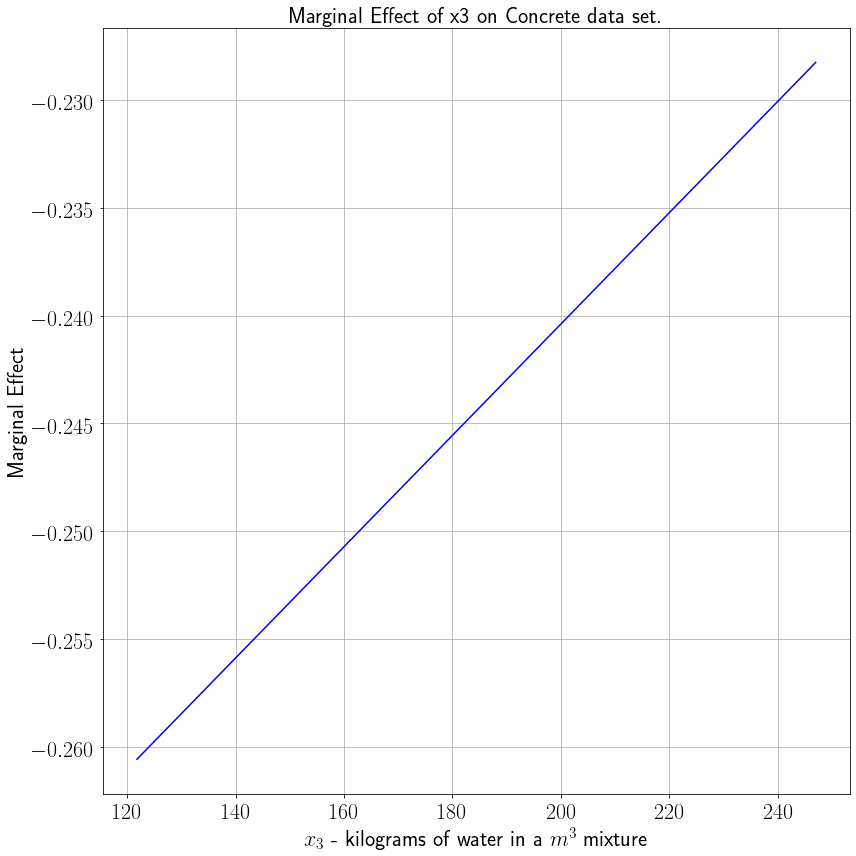

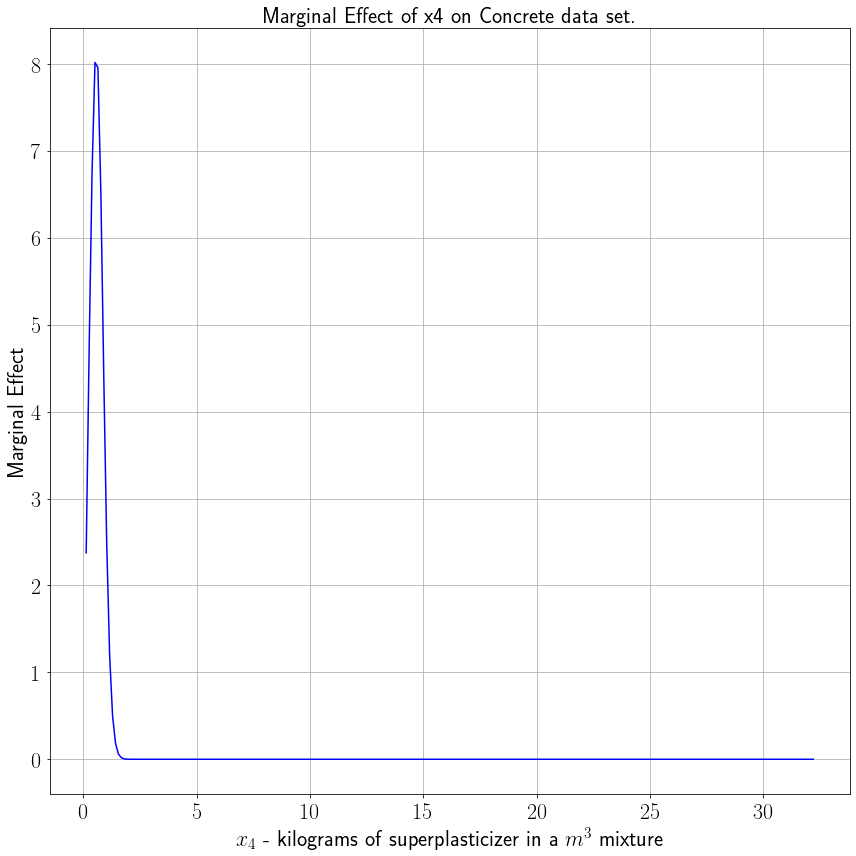

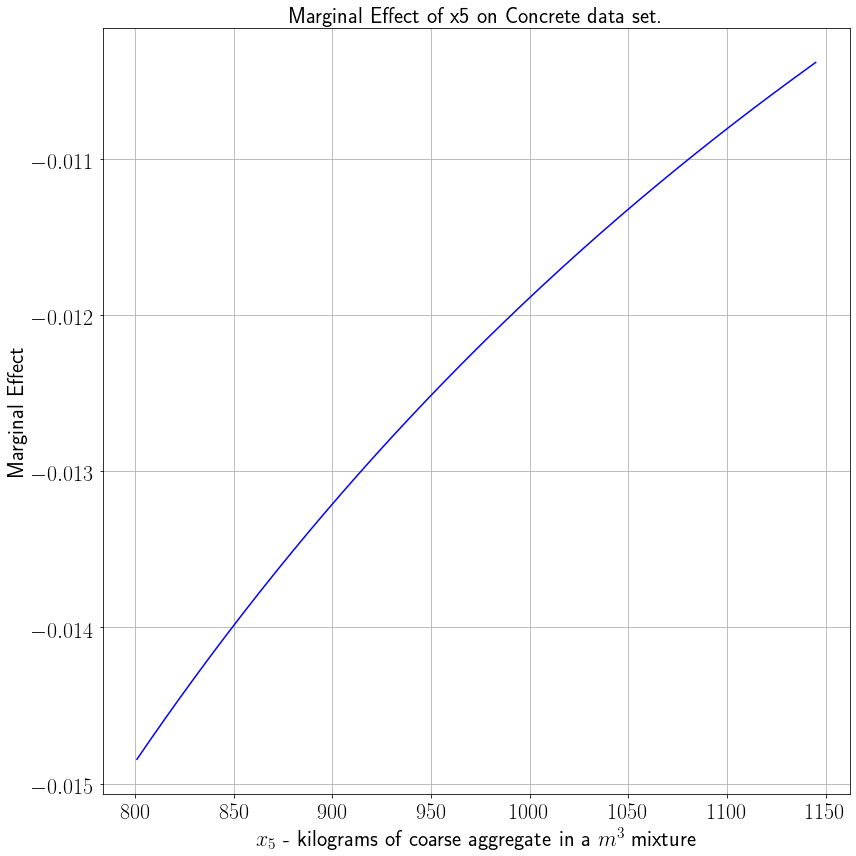

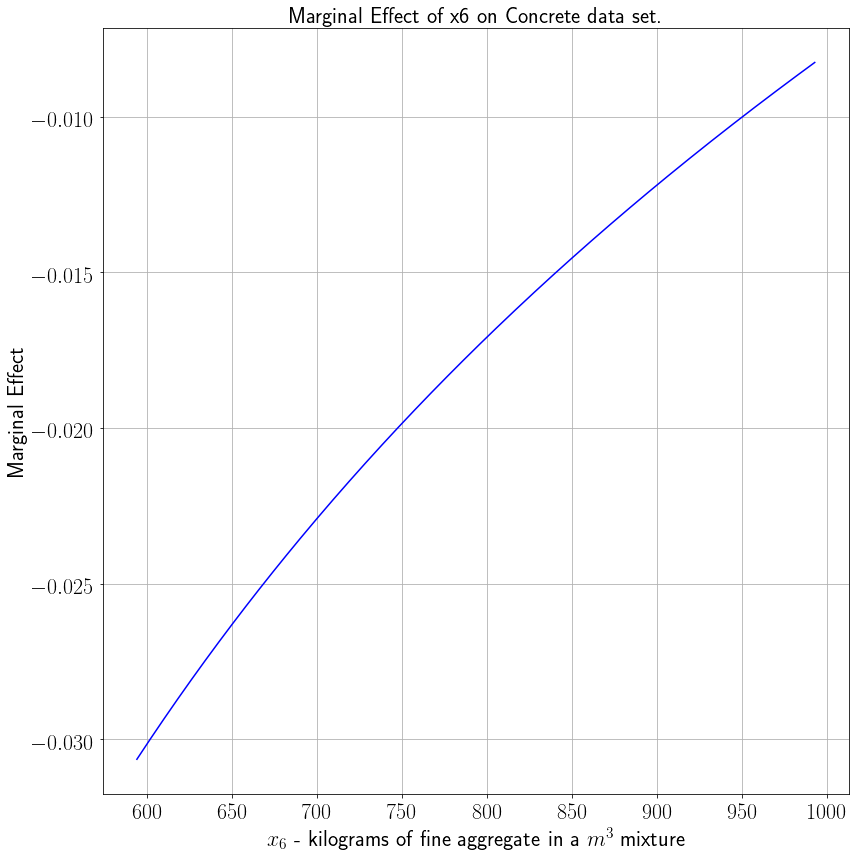

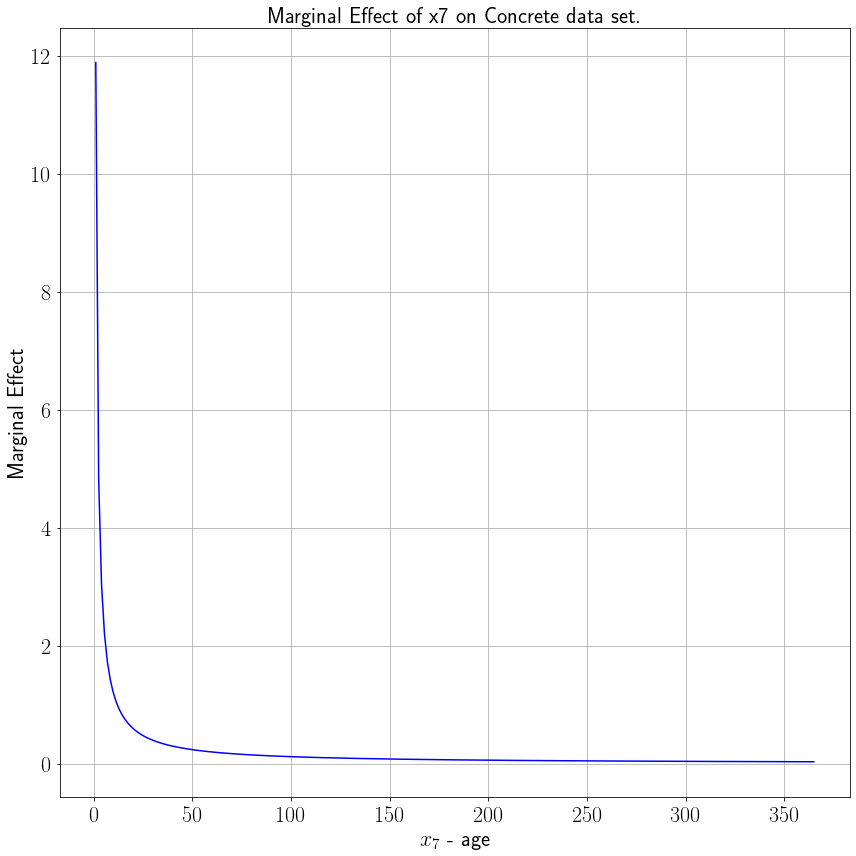

In [5]:
# Creating the expression and fitting
itexpr = sr.ITExpr(
    (np.array([
        [ 0,  0,  0,  1,  0,  0,  1,  1],
        [-2,  0,  0,  0,  0,  1,  2, -1],
        [ 2,  0,  0,  1,  2, -2,  0, -1],
        [ 0,  0,  0,  1,  0,  0,  0,  0],
        [ 0,  1,  0,  2,  0,  0,  2,  0],
    ]),
     [
        'sqrt.abs',
        'log',
        'tanh',
        'id',
        'id'
    ]),
    transf_funs
)

# Energy heating -> 9 explanatory variables 
_ = itexpr.fit(linear_model.LinearRegression(fit_intercept=True), X, y)

print(itexpr)
print(itexpr.fitness)
print(itexpr.coeffs)

w = Wrapper(transf_funs, transf_funs_dx, itexpr, X, y, [])

w.MEM('mean', show_err=False, save_path='../../../results/iteaMarginalEffect/MEM', show=True)

dxs = pd.Series()

dxs['ITExpr'] = w._IT_to_latex()

for i in range(len(X[0])):
    try:
        latex    = w._IT_dx_to_latex(i)

        dxs[r'\frac{\partial}{\partial ' + str(i) + '}ITExpr'] = latex
    except Exception as e:
        continue

for k, v in dxs.iteritems(): 
    display(Latex(f'${k}$: ${v}$'))